# Question 2 : Faster RCNN Based Model Object Detection


## Task :

<ul>
<li>Train model Faster RCNN for object detection in dataset Pascal VOC </li>
</ul>


## Model Description

**Convolutional Layer:**
Convolutional layers are fundamental building blocks in convolutional neural networks (CNNs). They perform convolutions on input images using learnable filters (kernels), which helps in capturing hierarchical features of the input data. In Faster R-CNN, convolutional layers are used to extract feature maps from the input images.

**RPN (Region Proposal Network):**
The RPN is a part of the Faster R-CNN architecture responsible for proposing candidate object regions within the feature map generated by the convolutional layers. It operates by sliding a small network (often a few convolutional layers) over the feature map, predicting whether there is an object or not, and suggesting bounding box proposals.

**ROI (Region of Interest) Pooling:**
After obtaining region proposals from the RPN, the ROI pooling layer is used to extract fixed-size feature maps from each proposed region. Since the proposed regions may have different sizes, ROI pooling ensures that they are all resized to a consistent size. This is important for feeding the proposals into subsequent layers for further processing.

**Classification Layer:**
The classification layer is responsible for classifying the content within each region proposal. In Faster R-CNN, it typically involves two sub-tasks: object classification (determining the class of the object within the proposal) and bounding box regression (refining the coordinates of the bounding box). This layer is often connected to the ROI-pooled feature maps and produces final class scores and bounding box coordinates for each proposed region.

## Import Libraries

In [1]:
from torch.utils.data import DataLoader
from torchvision.models.detection import fasterrcnn_resnet50_fpn
import math
import sys
import time
import torch
import os
from scipy.io import loadmat
from google.colab import drive
import random
import matplotlib.pyplot as plt
from PIL import Image
import xml.etree.ElementTree as ET
import torchvision.models as models
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
import warnings

warnings.filterwarnings('ignore')

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
gpu = True

if gpu == True:
    device = torch.device('cuda')
else:
    device = torch.device('cpu')

Gathering dataset folder

In [4]:
source_path = '/content/drive/MyDrive/Wildfire Smoke.v1-raw.voc/'
destination_path = '/content/dataset'
!cp -r "$source_path" "$destination_path"


## Preprocess

Show Images ( 5 random selected ) + labels

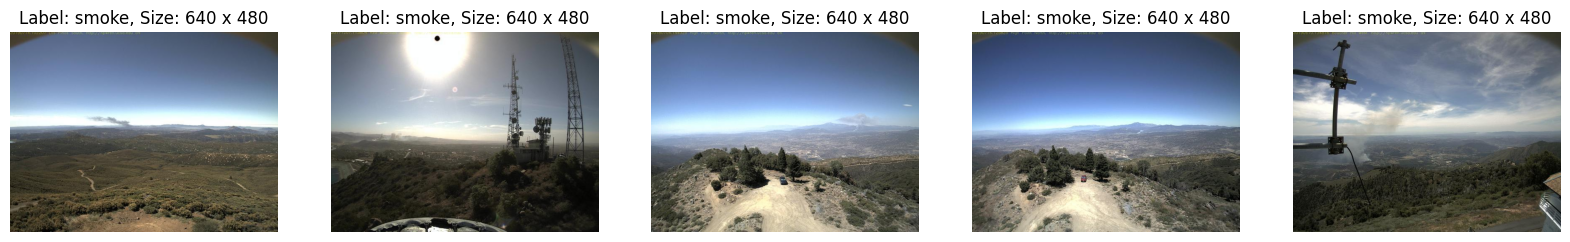

In [5]:


# Paths
xml_folder = '/content/dataset/train'
image_folder = '/content/dataset/train'


def extract_info(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()

    label = root.find('.//name').text

    size_elem = root.find('.//size')
    width = int(size_elem.find('width').text)
    height = int(size_elem.find('height').text)

    return label, width, height

xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]

import random
random.seed(42)
selected_files = random.sample(xml_files, 5)

plt.figure(figsize=(20, 3))

for i, xml_file in enumerate(selected_files):
    xml_path = os.path.join(xml_folder, xml_file)

    label, width, height = extract_info(xml_path)

    plt.subplot(1, 5, i + 1)
    plt.imshow(Image.open(os.path.join(image_folder, xml_file.replace('.xml', '.jpg'))))
    plt.title(f"Label: {label}, Size: {width} x {height}")
    plt.axis('off')

plt.show()


get number of classes

In [6]:
def extract_labels(xml_path):
    tree = ET.parse(xml_path)
    root = tree.getroot()
    # Extract label
    label = root.find('.//name').text
    return label

In [7]:
xml_files = [f for f in os.listdir(xml_folder) if f.endswith('.xml')]
unique_labels = set()

for xml_file in xml_files:
    xml_path = os.path.join(xml_folder, xml_file)

    # Extract label
    label = extract_labels(xml_path)

    # Add label to set
    unique_labels.add(label)

# Number of unique labels
num_unique_labels = len(unique_labels)

print(f"Number of unique labels: {num_unique_labels}")
print("Unique Labels:", unique_labels)

Number of unique labels: 1
Unique Labels: {'smoke'}


resize images

In [16]:
desired_size = (800, 800)


In [17]:
folders = ['/content/dataset/train', '/content/dataset/valid', '/content/dataset/test']


In [18]:
def resize_image_and_xml(image_path, xml_path):
    img = Image.open(image_path)
    img = img.resize(desired_size)

    tree = ET.parse(xml_path)
    root = tree.getroot()

    size_elem = root.find('.//size')
    size_elem.find('width').text = str(desired_size[0])
    size_elem.find('height').text = str(desired_size[1])

    tree.write(xml_path)

    img.save(image_path)
    print(f"Resized image shape: {img.size}")

In [19]:
for folder in folders:
    # Get list of image files
    image_files = [f for f in os.listdir(folder) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

    # Loop through each image file
    for image_file in image_files:
        image_path = os.path.join(folder, image_file)
        xml_path = os.path.join(folder, image_file.replace('.jpg', '.xml').replace('.jpeg', '.xml').replace('.png', '.xml'))

        # Resize image and update XML
        resize_image_and_xml(image_path, xml_path)

print("Images and XML files have been resized and updated.")

Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized image shape: (800, 800)
Resized 

## Prepare the data

In [8]:
import torch
from torch.utils.data import Dataset
import cv2
import pandas as pd
import numpy as np
from torch.utils.data import DataLoader


In [9]:
class_mapping = {'smoke': 1}

In [10]:

class WildFireSmoke_Dataset(Dataset):
    def __init__(self, image_path, categories, transforms=None):
        self.image_path = image_path
        self.categories = categories
        self.transforms = transforms
        self.df = self.load_data()
        self.images = self.df['filename'].unique()

        # Extract unique labels from the dataset
        xml_files = [f for f in os.listdir(self.image_path) if f.endswith('.xml')]
        unique_labels = set()

        for xml_file in xml_files:
            xml_path = os.path.join(self.image_path, xml_file)
            label = extract_labels(xml_path)
            unique_labels.add(label)

        self.unique_labels = list(unique_labels)

    def load_data(self):
        data  = {'filename': [], 'width': [], 'height': [], 'xmin': [], 'ymin': [], 'xmax': [], 'ymax': [], 'class': []}
        xml_files = [f for f in os.listdir(self.image_path) if f.endswith('.xml')]
        xml_files = [f for f in os.listdir(self.image_path) if f.endswith('.xml')]

        for xml_file in xml_files:
            xml_path = os.path.join(self.image_path, xml_file)
            tree = ET.parse(xml_path)
            root = tree.getroot()

            filename = root.find('.//filename').text
            width = int(root.find('.//width').text)
            height = int(root.find('.//height').text)

            for obj in root.findall('.//object'):
                class_name = obj.find('.//name').text
                bbox = obj.find('.//bndbox')
                xmin = int(bbox.find('.//xmin').text)
                ymin = int(bbox.find('.//ymin').text)
                xmax = int(bbox.find('.//xmax').text)
                ymax = int(bbox.find('.//ymax').text)

                data['filename'].append(filename)
                data['width'].append(width)
                data['height'].append(height)
                data['xmin'].append(xmin)
                data['ymin'].append(ymin)
                data['xmax'].append(xmax)
                data['ymax'].append(ymax)
                data['class'].append(class_name)

        df = pd.DataFrame(data)
        return df

        pass

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        image_file = os.path.join(self.image_path,self.df.iloc[idx]['filename'])
        img = cv2.imread(image_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = img.astype(np.float32) / 255.0

        image_data = self.df[self.df['filename'] == self.df.iloc[idx]['filename']]
        xmins = image_data['xmin'].values
        ymins = image_data['ymin'].values
        xmaxs = image_data['xmax'].values
        ymaxs = image_data['ymax'].values

        boxes = torch.as_tensor(np.stack([xmins, ymins, xmaxs, ymaxs], axis=1), dtype=torch.float32)
        labels = torch.as_tensor(image_data['class'].values, dtype=torch.int64)
        image_id = torch.tensor([idx])
        areas = (boxes[:,3] - boxes[:,1]) * (boxes[:,2] - boxes[:,0])
        areas = torch.as_tensor(areas, dtype=torch.float32)
        iscrowd = torch.zeros((len(labels),), dtype=torch.int64)

        target = {}
        target['boxes']    = boxes
        target['labels']   = labels
        target['image_id'] = image_id
        target['area']     = areas
        target['iscrowd']  = iscrowd


        return torch.as_tensor(img, dtype=torch.float32), target

    def get_height_and_width(self, image):
        image_data = self.df.loc[self.df['filename'] == image]
        return image_data['width'].values[0], image_data['height'].values[0]


In [11]:
train_path = '/content/dataset/train'
valid_path = '/content/dataset/valid'

In [12]:
train_dataset = WildFireSmoke_Dataset(image_path=train_path, categories=['smoke'])
valid_dataset = WildFireSmoke_Dataset(image_path=valid_path, categories=['smoke'])

train_loader = DataLoader(train_dataset, batch_size=4, num_workers = 2,shuffle=True)
valid_loader = DataLoader(train_dataset, batch_size=4,num_workers = 2, shuffle=False)


In [13]:
print(f"Length of train dataset: {len(train_dataset)}")
print(f"Length of valid dataset: {len(valid_dataset)}")

Length of train dataset: 516
Length of valid dataset: 147


In [14]:
train_dataset.df

filename  width  height  xmin  \
0    ck0ncye0iiouc0848ostst7bq_jpeg.rf.be5d0f452dbe...    640     480   326   
1    ck0t2z9knn3060944ppcr9fkn_jpeg.rf.55fb31c0cd4f...    640     480    96   
2    ck0twl6pqwg6c0721ja81m52m_jpeg.rf.a8b03e4b1a12...    640     480   448   
3    ck0khttiojrab0a46z2tgb5rd_jpeg.rf.10ff9460ea9b...    640     480    76   
4    ck0m15edijrbs0944olo8aqra_jpeg.rf.52e8a4303ab0...    640     480   189   
..                                                 ...    ...     ...   ...   
511  ck0l9dfokcv7o07013t4kgamc_jpeg.rf.a96fed0753b1...    640     480   126   
512  ck0rqq0y3j4tu0848p884qvn1_jpeg.rf.654a70a2e86f...    640     480   329   
513  ck0nexpddii7b0a463cb74ti7_jpeg.rf.80335414ee96...    640     480   470   
514  ck0km3uktkdxc0a46uf6e417v_jpeg.rf.b37895e0f3e5...    640     480   220   
515  ck0l8askp96bh0794bppil14t_jpeg.rf.d00754fce818...    640     480   222   

     ymin  xmax  ymax  class  
0     223   420   253  smoke  
1     232   178   265  smoke  
2     212   619   283  smoke  
3     230   264   291  smoke  
4     207   209   225  smoke  
..    ...   ...   ...    ...  
511   194   201   315  smoke  
512   202   439   254  smoke  
513   215   615   288  smoke  
514   208   257   240  smoke  
515   212   257   233  smoke  

[516 rows x 8 columns]

In [15]:
train_dataset.df['class'] = train_dataset.df['class'].map(class_mapping)
valid_dataset.df['class'] = valid_dataset.df['class'].map(class_mapping)

In [16]:
train_dataset.df

filename  width  height  xmin  \
0    ck0ncye0iiouc0848ostst7bq_jpeg.rf.be5d0f452dbe...    640     480   326   
1    ck0t2z9knn3060944ppcr9fkn_jpeg.rf.55fb31c0cd4f...    640     480    96   
2    ck0twl6pqwg6c0721ja81m52m_jpeg.rf.a8b03e4b1a12...    640     480   448   
3    ck0khttiojrab0a46z2tgb5rd_jpeg.rf.10ff9460ea9b...    640     480    76   
4    ck0m15edijrbs0944olo8aqra_jpeg.rf.52e8a4303ab0...    640     480   189   
..                                                 ...    ...     ...   ...   
511  ck0l9dfokcv7o07013t4kgamc_jpeg.rf.a96fed0753b1...    640     480   126   
512  ck0rqq0y3j4tu0848p884qvn1_jpeg.rf.654a70a2e86f...    640     480   329   
513  ck0nexpddii7b0a463cb74ti7_jpeg.rf.80335414ee96...    640     480   470   
514  ck0km3uktkdxc0a46uf6e417v_jpeg.rf.b37895e0f3e5...    640     480   220   
515  ck0l8askp96bh0794bppil14t_jpeg.rf.d00754fce818...    640     480   222   

     ymin  xmax  ymax  class  
0     223   420   253      1  
1     232   178   265      1  
2     212   619   283      1  
3     230   264   291      1  
4     207   209   225      1  
..    ...   ...   ...    ...  
511   194   201   315      1  
512   202   439   254      1  
513   215   615   288      1  
514   208   257   240      1  
515   212   257   233      1  

[516 rows x 8 columns]

showing a sample from dataset train to check if everything is fine

In [17]:
train_dataset[1]

(tensor([[[0.6980, 0.6980, 0.6039],
          [0.5961, 0.5961, 0.5020],
          [0.7608, 0.7608, 0.6588],
          ...,
          [0.2824, 0.2824, 0.2431],
          [0.5843, 0.5843, 0.5451],
          [0.4824, 0.4824, 0.4431]],
 
         [[0.7451, 0.7451, 0.6431],
          [0.6824, 0.6824, 0.5804],
          [0.7373, 0.7373, 0.6275],
          ...,
          [0.1647, 0.1647, 0.1255],
          [0.5765, 0.5765, 0.5373],
          [0.1882, 0.1882, 0.1490]],
 
         [[0.2863, 0.2902, 0.1647],
          [0.3333, 0.3373, 0.2118],
          [0.3137, 0.3176, 0.1922],
          ...,
          [0.2235, 0.2235, 0.1765],
          [0.2667, 0.2667, 0.2196],
          [0.1961, 0.1961, 0.1490]],
 
         ...,
 
         [[0.0863, 0.0941, 0.0510],
          [0.0902, 0.0980, 0.0549],
          [0.0941, 0.1020, 0.0588],
          ...,
          [0.0314, 0.0314, 0.0235],
          [0.0275, 0.0275, 0.0196],
          [0.0275, 0.0275, 0.0196]],
 
         [[0.1059, 0.1137, 0.0706],
          [0

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

In [19]:
data_loader_train = torch.utils.data.DataLoader(
        train_dataset,
        batch_size  = 4,
        shuffle     = True,
        num_workers = 2,
        collate_fn  = collate_fn)

data_loader_valid = torch.utils.data.DataLoader(
        valid_dataset,
        batch_size  = 4,
        shuffle     = False,
        num_workers = 2,
        collate_fn  = collate_fn)


## Plot images and boxes

In [45]:
def plot_images(images, targets):

    max_images = 4
    count_imgs = 0

    for image, target in zip(images, targets):

        if count_imgs == max_images:
            break;

        count_imgs += 1

        # Get the image and the boxes in the right format
        sample = image.cpu().numpy()
        boxes  = target['boxes'].cpu().numpy().astype(np.int32)

        print(image.shape)
        print(sample.shape)

        fig, ax = plt.subplots(1, 1, figsize=(10, 8))
        # Plot the boxes
        for box in boxes:
            cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (1,0,0), 2);

            cv2.putText(sample, 'SMOKE',
                      (box[0], box[1]-10), cv2.FONT_HERSHEY_DUPLEX, 0.8, (1,0,0), 2)

        # Additional
        ax.set_axis_off();
        ax.imshow((sample * 255).astype(np.uint8))


torch.Size([480, 640, 3])
(480, 640, 3)
torch.Size([480, 640, 3])
(480, 640, 3)
torch.Size([480, 640, 3])
(480, 640, 3)
torch.Size([480, 640, 3])
(480, 640, 3)


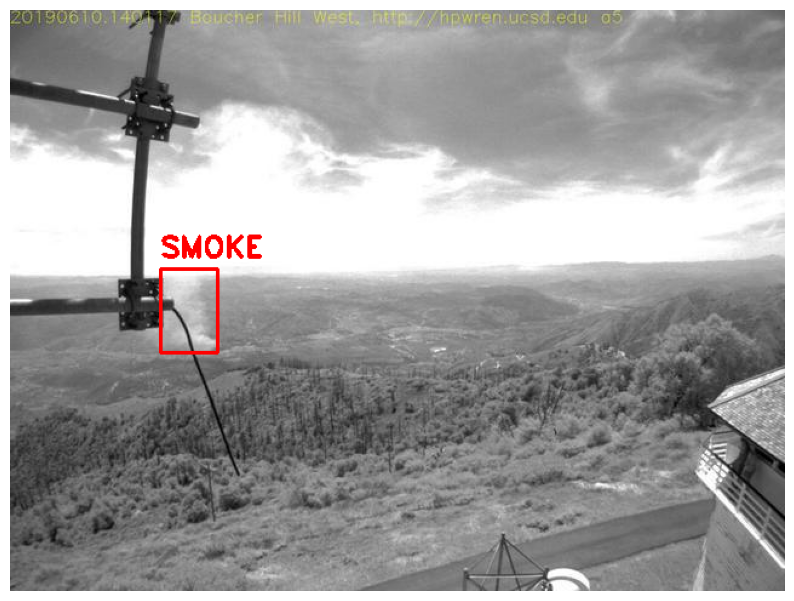

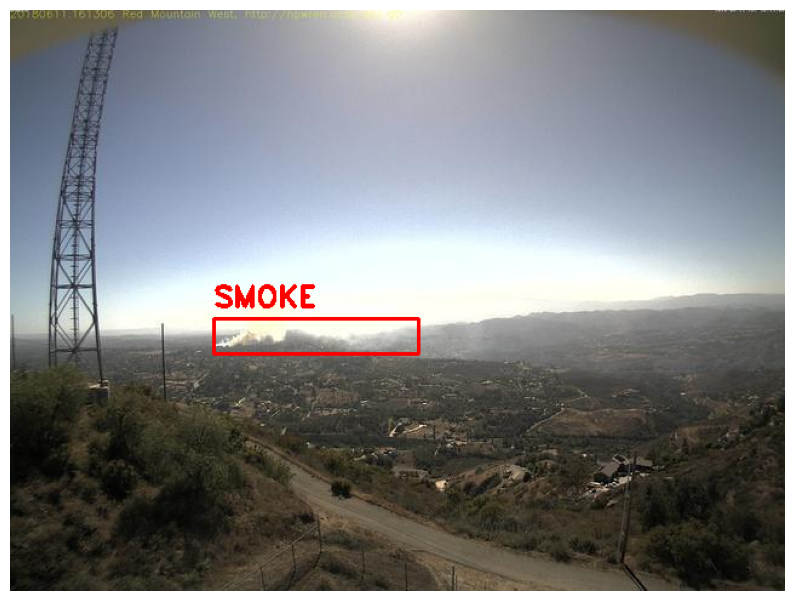

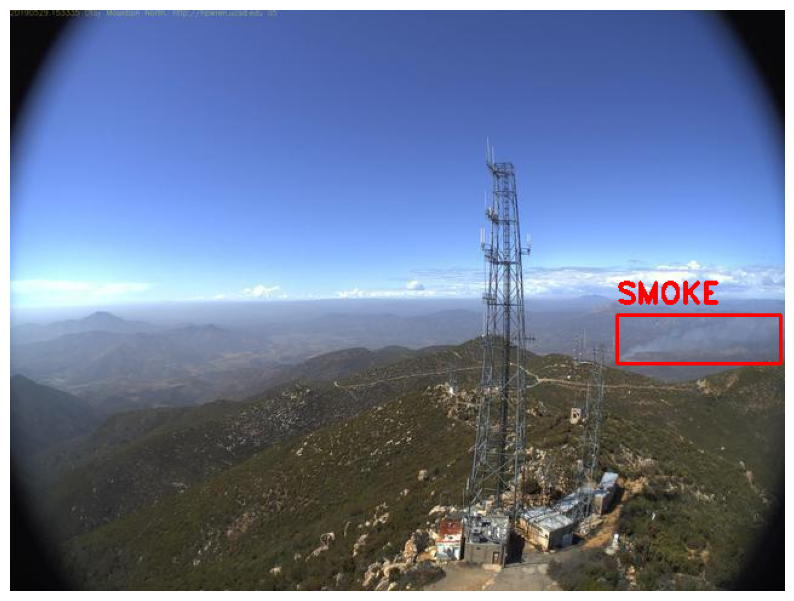

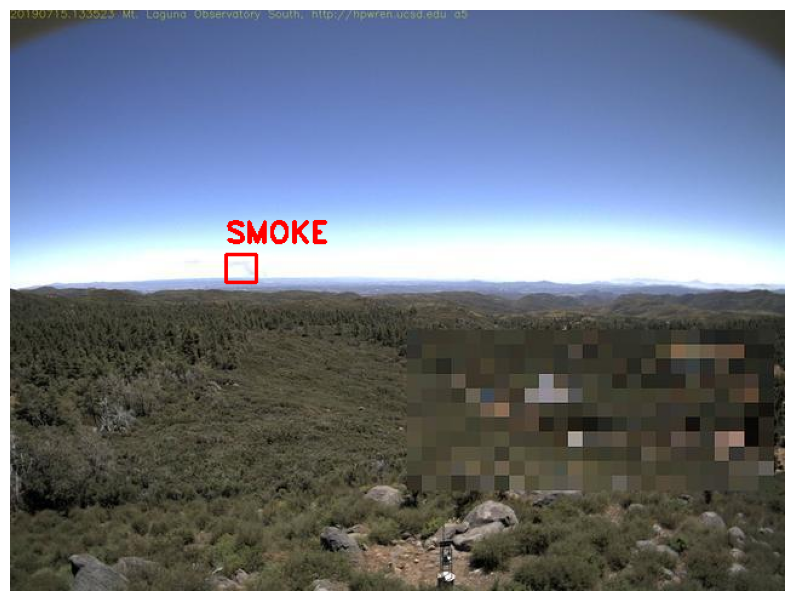

In [46]:
images, targets = next(iter(data_loader_train))

plot_images(images,targets)


torch.Size([480, 640, 3])
(480, 640, 3)
torch.Size([480, 640, 3])
(480, 640, 3)
torch.Size([480, 640, 3])
(480, 640, 3)
torch.Size([480, 640, 3])
(480, 640, 3)


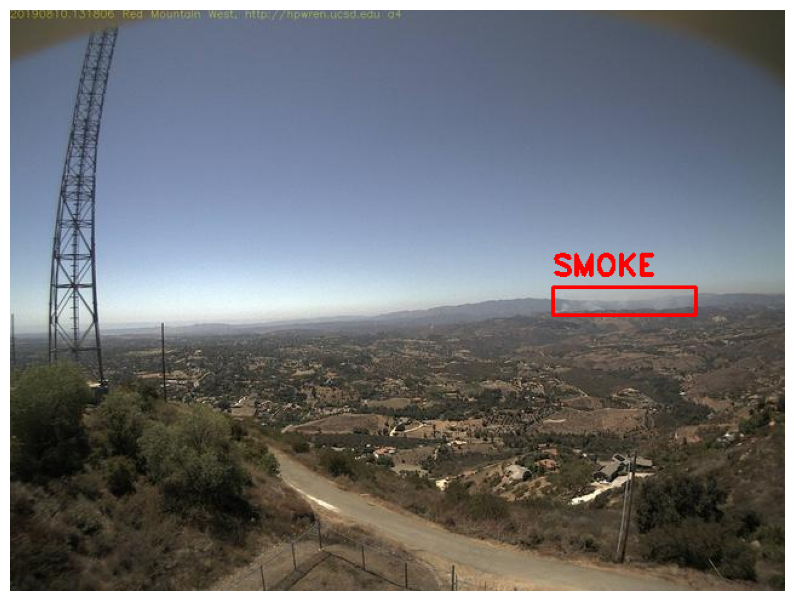

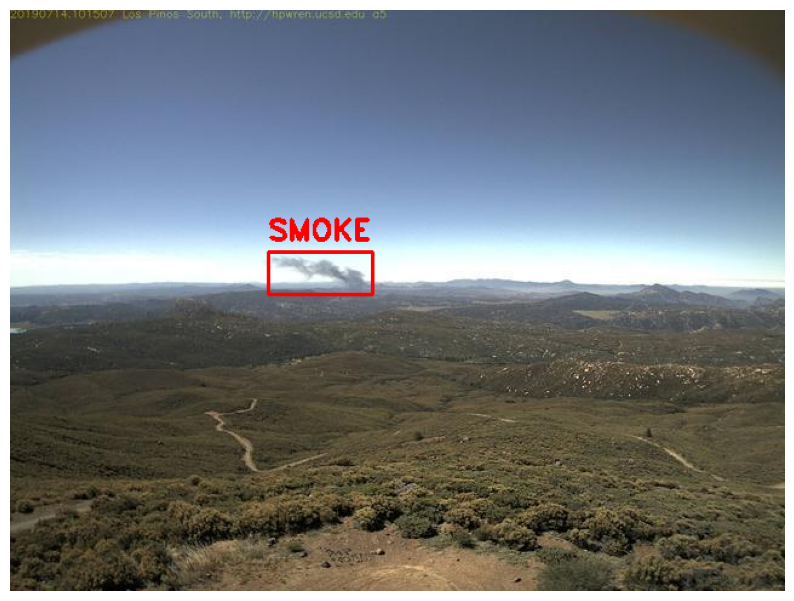

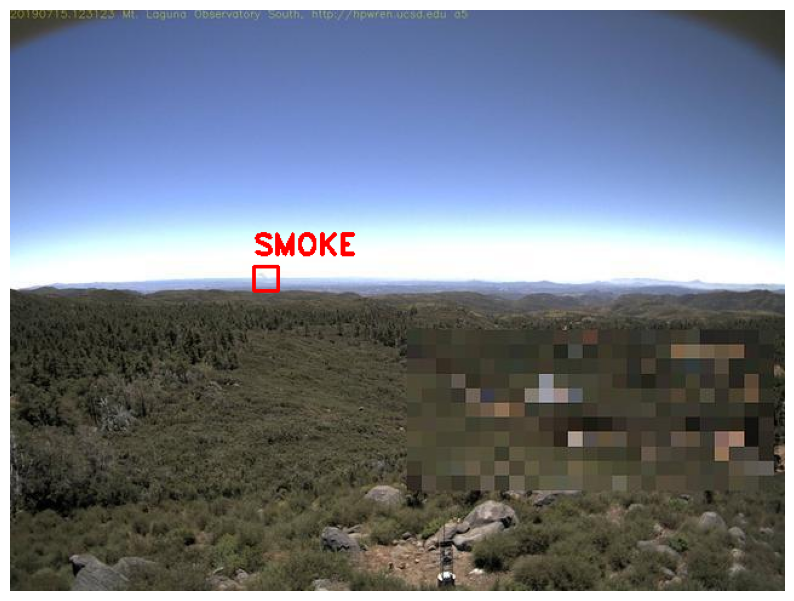

In [47]:
images, targets = next(iter(data_loader_valid))
plot_images(images, targets)

##Model & Dataset

### Import model pre-train

In [59]:
import torch.nn as nn
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from engine import train_one_epoch, evaluate

Available models, pre-trained on COCO dataset, at https://pytorch.org/vision/master/models/faster_rcnn.html.



In [83]:
model = fasterrcnn_resnet50_fpn(pretrained=True)


### Adjust the classifier

In [84]:
num_classes = 2 # number of classes (len(categories) + 'background')
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)



In [85]:
detection_model = model.to(device)

check the model is added right or not !

In [86]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

### Training

Model modifications based on paper

In [68]:
class CustomBackbone(nn.Module):
    def __init__(self):
        super(CustomBackbone, self).__init__()
        self.conv_layers = self._make_conv_layers()
        self.pool_layers = self._make_pool_layers()

    def _make_conv_layers(self):
        return nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),

            nn.Conv2d(3, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True),
            nn.Conv2d(64, 64, kernel_size=3, padding=1), nn.ReLU(inplace=True)

        )

    def _make_pool_layers(self):
        return nn.Sequential(
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.MaxPool2d(kernel_size=2, stride=2)

        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.pool_layers(x)
        return x


In [69]:
import torchvision.ops as ops

class ProposalLayer(nn.Module):
    def __init__(self, pre_nms_topN=6000, post_nms_topN=300, nms_thresh=0.7):
        super(ProposalLayer, self).__init__()
        self.pre_nms_topN = pre_nms_topN
        self.post_nms_topN = post_nms_topN
        self.nms_thresh = nms_thresh

    def forward(self, rpn_locs, rpn_scores, anchors, image_size):
        # Generate proposals based on RPN predicted offset and positive bounding box
        proposals = ops.box_decode(anchors, rpn_locs)

        # Process bbox exceeding image boundary
        proposals[:, 0::4] = torch.clamp(proposals[:, 0::4], 0, image_size[1])
        proposals[:, 1::4] = torch.clamp(proposals[:, 1::4], 0, image_size[0])
        proposals[:, 2::4] = torch.clamp(proposals[:, 2::4], 0, image_size[1])
        proposals[:, 3::4] = torch.clamp(proposals[:, 3::4], 0, image_size[0])

        # Remove bboxes less than the threshold
        keep = (proposals[:, 2] > proposals[:, 0]) & (proposals[:, 3] > proposals[:, 1])
        proposals = proposals[keep]

        # Sort all (proposal, score) pairs from high to low according to the value of the score
        _, order = torch.sort(rpn_scores, descending=True)
        proposals = proposals[order]

        # Take the first pre_nms_topN values
        proposals = proposals[:self.pre_nms_topN]

        # Perform NMS on the remaining positive proposals
        keep = ops.nms(proposals[:, :4], proposals[:, 4], self.nms_thresh)

        # Take the top post_nms_topN values after NMS
        keep = keep[:self.post_nms_topN]
        proposals = proposals[keep]

        return proposals


In [70]:
class CustomRoIPooling(nn.Module):
    def __init__(self, pooled_height, pooled_width, spatial_scale):
        super(CustomRoIPooling, self).__init__()
        self.pooled_height = pooled_height
        self.pooled_width = pooled_width
        self.spatial_scale = spatial_scale

    def forward(self, feature_map, proposals):
        # Transform proposals to the feature map coordinates
        proposals[:, 0::4] /= self.spatial_scale
        proposals[:, 1::4] /= self.spatial_scale
        proposals[:, 2::4] /= self.spatial_scale
        proposals[:, 3::4] /= self.spatial_scale

        # Perform RoI pooling
        pooled_features = ops.roi_pool(feature_map, proposals, (self.pooled_height, self.pooled_width))

        return pooled_features



In [71]:
num_classes = len(unique_labels) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [72]:
custom_backbone = CustomBackbone()
proposal_layer = ProposalLayer()
roi_pooling_layer = CustomRoIPooling(pooled_height=7, pooled_width=7, spatial_scale=1/16)
num_classes = len(unique_labels) + 1
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

In [87]:
model

FasterRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(

## Train and fit model

In [88]:
import torch
import torchvision
from torchvision.models.detection import fasterrcnn_resnet50_fpn
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor
from torchvision.models.detection.rpn import AnchorGenerator
import torchvision.transforms.functional as TF

In [91]:
num_epochs = 1
optimizer = torch.optim.SGD(model.parameters(), lr=0.005, momentum=0.9, weight_decay=0.0005)
